# HW 1 – Frequent Pattern Mining

Name: Jimmy (Qixiao) Zhu
Class: CSCI 349 - Intro to Data Mining
Semester: 2023SP
Instructor: Brian King

ChatGPT is used.

In [934]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mlxtend.frequent_patterns import fpgrowth, association_rules, apriori

##### Read in the four datasets as Pandas dataframes #####

In [935]:
# read in datasets

links = pd.read_csv("../data/ml-latest-small/links.csv")
movies = pd.read_csv("../data/ml-latest-small/movies.csv")
ratings = pd.read_csv("../data/ml-latest-small/ratings.csv")
tags = pd.read_csv("../data/ml-latest-small/tags.csv")

## Properly Format and Type the Datasets ##

##### Checkout the Dataframes and convert them to right types #####

In [936]:
# know the basic structure of the links

links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [937]:
# info of links

links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


##### We notice right away that the IDs are all categorical data, so we convert them #####

In [938]:
# convert to categorical data

links["movieId"] = links["movieId"].astype('category')
links["imdbId"] = links["imdbId"].astype('category')
links["tmdbId"] = links["tmdbId"].astype('category')
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   movieId  9742 non-null   category
 1   imdbId   9742 non-null   category
 2   tmdbId   9734 non-null   category
dtypes: category(3)
memory usage: 1.0 MB


In [939]:
# same process as above

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [940]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


##### We will convert movieId and title to categorical data, and binarize genres into 0 and 1 unsigned integers #####

In [941]:
# binarize and downcast movies

movies["movieId"] = movies["movieId"].astype('category')
movies["title"] = movies["title"].astype('category')

# ChatGPT
# for the "genres" column, we binarize it by separating the categories by '|'
binary_df = movies["genres"].str.get_dummies('|')

# downcast the binarized columns
downcasted = binary_df.astype({col: 'uint8' for col in binary_df.columns})

# concatenate the original and binary dataframes
movies = pd.concat([movies, downcasted], axis=1)

# drop the original 'Color' column
movies = movies.drop("genres", axis=1)

# drop the no genres listed column because we will know it when a movie does not have a genre
movies = movies.drop("(no genres listed)", axis=1)

movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   movieId      9742 non-null   category
 1   title        9742 non-null   category
 2   Action       9742 non-null   uint8   
 3   Adventure    9742 non-null   uint8   
 4   Animation    9742 non-null   uint8   
 5   Children     9742 non-null   uint8   
 6   Comedy       9742 non-null   uint8   
 7   Crime        9742 non-null   uint8   
 8   Documentary  9742 non-null   uint8   
 9   Drama        9742 non-null   uint8   
 10  Fantasy      9742 non-null   uint8   
 11  Film-Noir    9742 non-null   uint8   
 12  Horror       9742 non-null   uint8   
 13  IMAX         9742 non-null   uint8   
 14  Musical      9742 non-null   uint8   
 15  Mystery      9742 non-null   uint8   
 16  Romance      9742 non-null   uint8   
 17  Sci-Fi       9742 non-null   uint8   
 18  Thriller     9742 non-null  

In [942]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [943]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


##### We will convert userId and movieId into categorical data, but rating might be useful to keep it as float, since we might be calculating something with it (average etc.). We just downcast rating and timestamp to get a smaller footprint (take up less memory) #####

In [944]:
# downcast ratings

ratings["userId"] = ratings["userId"].astype('category')
ratings["movieId"] = ratings["movieId"].astype('category')
ratings["rating"] = pd.to_numeric(ratings["rating"], downcast='float')
ratings["timestamp"] = pd.to_numeric(ratings["timestamp"], downcast='integer')

ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   userId     100836 non-null  category
 1   movieId    100836 non-null  category
 2   rating     100836 non-null  float32 
 3   timestamp  100836 non-null  int32   
dtypes: category(2), float32(1), int32(1)
memory usage: 1.5 MB


In [945]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [946]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


##### Same process as before, but timestamp can be downcasted to have a smaller footprint #####

In [947]:
# downcast tags

tags["userId"] = tags["userId"].astype('category')
tags["movieId"] = tags["movieId"].astype('category')
tags["tag"] = tags["tag"].astype('category')
tags["timestamp"] = pd.to_numeric(tags["timestamp"], downcast='integer')

tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   userId     3683 non-null   category
 1   movieId    3683 non-null   category
 2   tag        3683 non-null   category
 3   timestamp  3683 non-null   int32   
dtypes: category(3), int32(1)
memory usage: 156.5 KB


## Phase I - EDA ##

### Distribution of the Number of Ratings by Movie ###

In [948]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


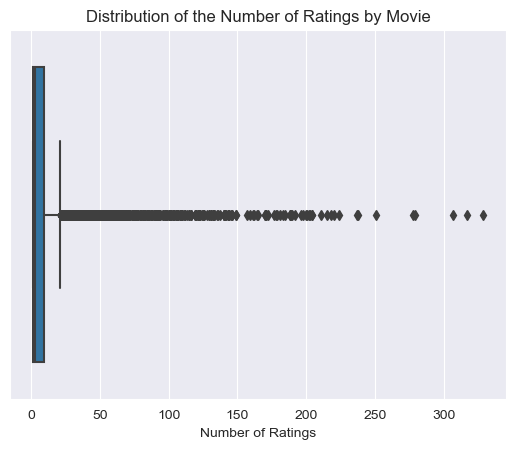

In [949]:
distribution_by_movie = ratings.value_counts("movieId")
sns.boxplot(x=distribution_by_movie.values)
plt.title("Distribution of the Number of Ratings by Movie")
plt.xlabel("Number of Ratings")
plt.show()

##### From the table above, we see that the majority of number of ratings per movie is around 5 to 20. This is the IQR (Inter Quartile Range). The average is a single digit number. There are a lot of outliers above 25, however. The largest outlier goes up to around 325, which means some particular movies are a lot more popular than most of the movies in the dataset. #####

### Distribution of the Number of Ratings by User ###

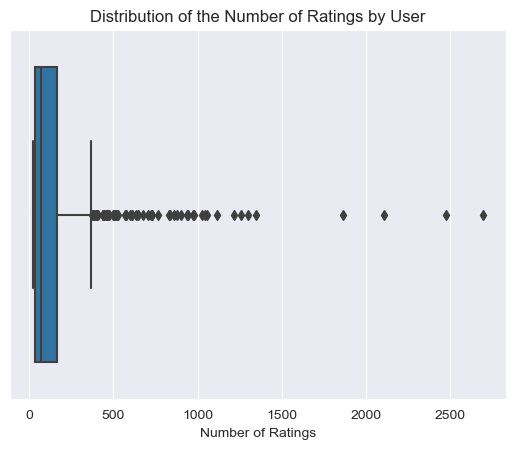

In [950]:
distribution_by_user = ratings.value_counts("userId")
sns.boxplot(x=distribution_by_user.values)
plt.title("Distribution of the Number of Ratings by User")
plt.xlabel("Number of Ratings")
plt.show()

##### From the table above about the number of ratings per user, we can see that most users rate around 50 to 200 movies (IQR), with an average at 100 ratings. The users with number of ratings above 400 are considered outliers. The highest user rates somewhere around 2740 movies. #####

### Movies with the Most Ratings ###

In [951]:
# when using value counts, the top ones are the largest rows

top_5_by_movies = ratings.value_counts("movieId").head()
top_5_by_movies.name = "ratings"
top_5_by_movies

movieId
356     329
318     317
296     307
593     279
2571    278
Name: ratings, dtype: int64

In [952]:
# find each of tem in movies and stack them

print("The top five movies with the highest number of ratings are: ")
df1 = movies[(movies["movieId"] == top_5_by_movies.index[0])]
df2 = movies[(movies["movieId"] == top_5_by_movies.index[1])]
df3 = movies[(movies["movieId"] == top_5_by_movies.index[2])]
df4 = movies[(movies["movieId"] == top_5_by_movies.index[3])]
df5 = movies[(movies["movieId"] == top_5_by_movies.index[4])]
table = pd.concat([df1, df2, df3, df4, df5], axis=0).loc[:, "movieId":"title"]
table = pd.merge(left=table, right=top_5_by_movies, how='left', on="movieId")
table

The top five movies with the highest number of ratings are: 


,movieId,title,ratings
0,356,Forrest Gump (1994),329
1,318,"Shawshank Redemption, The (1994)",317
2,296,Pulp Fiction (1994),307
3,593,"Silence of the Lambs, The (1991)",279
4,2571,"Matrix, The (1999)",278


##### Above is a table of five movies that have the highest number of ratings on the platform. These movies are Forrest Gump, The Shawshank Redemption, Pulp Fiction, The Silence of the Lambs, and The Matrix. The other column is their number of ratings 329, 317, 307, 279, 278 for the corresponding five most popular movies. #####

### Movies with the Least Ratings ###

In [953]:
# after using value counts, we sort the values to ensure the smallest are at the top

least_5_by_movies = ratings.value_counts("movieId").sort_values(ascending=True).head()
least_5_by_movies.name = "ratings"
least_5_by_movies

movieId
193609    1
320       1
106785    1
161830    1
161918    1
Name: ratings, dtype: int64

In [954]:
# same stacking process

print("A lot of movies have only 1 rating (the lowest number of ratings, these are five of them: ")
df_1 = movies[(movies["movieId"] == least_5_by_movies.index[0])]
df_2 = movies[(movies["movieId"] == least_5_by_movies.index[1])]
df_3 = movies[(movies["movieId"] == least_5_by_movies.index[2])]
df_4 = movies[(movies["movieId"] == least_5_by_movies.index[3])]
df_5 = movies[(movies["movieId"] == least_5_by_movies.index[4])]
table1 = pd.concat([df_1, df_2, df_3, df_4, df_5], axis=0).loc[:, "movieId":"title"]
table1 = pd.merge(left=table1, right=least_5_by_movies, how='left', on="movieId")
table1

A lot of movies have only 1 rating (the lowest number of ratings, these are five of them: 


,movieId,title,ratings
0,193609,Andrew Dice Clay: Dice Rules (1991),1
1,320,Suture (1993),1
2,106785,Homefront (2013),1
3,161830,Body (2015),1
4,161918,Sharknado 4: The 4th Awakens (2016),1


##### There are a lot of movies with only one rating, these five are the examples. They are Andrew Dice Clay: Dice Rules, Suture, Homefront, Body, and Sharknado 4. #####

### Users with the Most Ratings ###

In [955]:
# if we count a number of ratings by the same id, we know that the user have given the ratings
# so we can just do the value count of the user ids

print("Top 5 Users with the Highest Number of Ratings are (userIds): ")
for i in range(5):
    print(ratings.value_counts("userId").head().index[i])

Top 5 Users with the Highest Number of Ratings are (userIds): 
414
599
474
448
274


### Users with the Least Ratings ###

In [956]:
# same process, but sort the output ascending

print("5 Users with the Lowest Number of Ratings are (userIds): ")
for i in range(5):
    print(ratings.value_counts("userId").sort_values(ascending=True).head().index[i])

5 Users with the Lowest Number of Ratings are (userIds): 
53
595
189
207
194


### Distribution of Number of Movies Watched per User ###

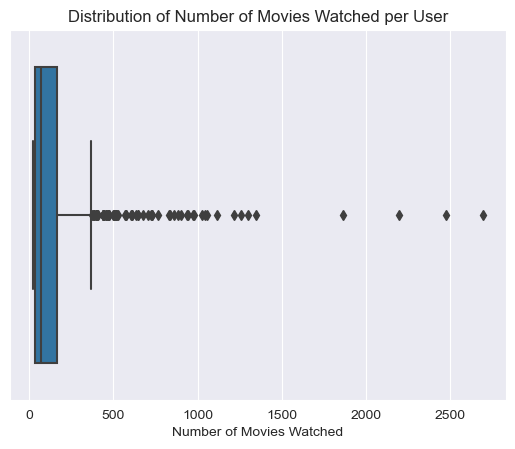

In [957]:
# union the ratings and tags userID and movieId columns
# because some users did not rate the movie but tagged the movie,
# and some did the other way

ratings_union_tags = \
    pd.concat([ratings.loc[:, "userId":"movieId"],
               tags.loc[:, "userId":"movieId"]], ignore_index=True).drop_duplicates()
distribution_per_user = ratings_union_tags.value_counts("userId")
sns.boxplot(x=distribution_per_user.values)
plt.title("Distribution of Number of Movies Watched per User")
plt.xlabel("Number of Movies Watched")
plt.show()

##### The above plot shows the distribution of number of movies watched per user. If we are taking a look at it, it looks very similar to the number of ratings. After doing the number of ratings plot, I discovered some users did not give some movies ratings, but they gave them tags instead. For this plot I also considered giving tags as the users watched the movies. The plot does not appear drastically different from the first one because there are not many users who only give tags to movies. #####

## Phase II ##

##### Because the ratings dataframe does not contain every movie in the movies dataframe, I will need to union the movies of the ratings dataframe with the movies of the movies dataframe to make sure that every movie is in the dataframe that I will be using. There will be no repetition and the movies will appear like transaction items in each purchase (binarized, 0 when the user did not watch, 1 when the user watched). I will then change the movie IDs to their corresponding names. The output shows the first 5 elements of the result_df dataframe that I will be using. #####

In [958]:
# take the dataframe of userid and movieid and binarize the movieid
# so that each movie is a column
users_list_movies = ratings.loc[:, "userId":"movieId"]
binarized_df = pd.get_dummies(users_list_movies["movieId"])

# concatenate the original dataframe with the binarized dataframe
result_df = pd.concat([users_list_movies, binarized_df], axis=1)
result_df = result_df.drop("movieId", axis=1)
result_df = result_df.groupby("userId").sum()

# Combine the index of the DataFrame with the index of the Series to create a new index object
new_columns = result_df.columns.union(movies["movieId"])

# Reindex the DataFrame using the new index object
result_df = result_df.reindex(columns=new_columns, fill_value=0)

# Make sure type is uint8
result_df = result_df.astype('uint8')

# Rename from movie ids to movie names
result_df.columns = movies["title"]

In [959]:
result_df.head()

title,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),GoldenEye (1995),...,Gintama: The Movie (2010),anohana: The Flower We Saw That Day - The Movie (2013),Silver Spoon (2014),Love Live! The School Idol Movie (2015),Jon Stewart Has Left the Building (2015),Black Butler: Book of the Atlantic (2017),No Game No Life: Zero (2017),Flint (2017),Bungo Stray Dogs: Dead Apple (2018),Andrew Dice Clay: Dice Rules (1991)
userId,,,,,,,,,,,,,,,,,,,,,
1,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [960]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 610 entries, 1 to 610
Columns: 9742 entries, Toy Story (1995) to Andrew Dice Clay: Dice Rules (1991)
dtypes: uint8(9742)
memory usage: 5.7 MB


##### Code above is just to check that the dataframe is of the right type, uint8. Because each item is either 0 or 1, we do not need other datatypes that might take up more memory. #####

In [961]:
# convert to boolean dataframe
result_bool = result_df.astype(bool)

In [962]:
# Mine frequent itemsets using FP-growth algorithm
frequent_itemsets = \
    fpgrowth(result_bool, min_support=0.3, use_colnames=True)
frequent_itemsets = \
    frequent_itemsets.sort_values(by='support', ascending=False, ignore_index=True)

frequent_itemsets.head(20)

,support,itemsets
0,0.539344,(Forrest Gump (1994))
1,0.519672,"(Shawshank Redemption, The (1994))"
2,0.503279,(Pulp Fiction (1994))
3,0.457377,"(Silence of the Lambs, The (1991))"
4,0.455738,"(Matrix, The (1999))"
5,0.411475,(Star Wars: Episode IV - A New Hope (1977))
6,0.390164,(Jurassic Park (1993))
7,0.388525,(Braveheart (1995))
8,0.378689,"(Forrest Gump (1994), Shawshank Redemption, Th..."
9,0.377049,"(Forrest Gump (1994), Pulp Fiction (1994))"


##### In this table above we calculated all the most frequent movies in the data set. We can see that Forrest Gump, The Shawshank Redemption, Pulp Fiction, and The Silence of the Lambs are the most popular. #####

In [963]:
# Generate association rules with a minimum confidence of 0.7
association_rules_df = \
    association_rules(frequent_itemsets, metric='confidence', min_threshold=0.7)

association_rules_df.sort_values(by=['lift', 'confidence'],
                                 ascending=False, ignore_index=True)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Star Wars: Episode V - The Empire Strikes Bac...,(Star Wars: Episode IV - A New Hope (1977)),0.345902,0.411475,0.311475,0.900474,2.188403,0.169145,5.913271
1,(Star Wars: Episode IV - A New Hope (1977)),(Star Wars: Episode V - The Empire Strikes Bac...,0.411475,0.345902,0.311475,0.756972,2.188403,0.169145,2.691454
2,(Star Wars: Episode IV - A New Hope (1977)),"(Matrix, The (1999))",0.411475,0.455738,0.300000,0.729084,1.599788,0.112475,2.008968
3,(Jurassic Park (1993)),(Forrest Gump (1994)),0.390164,0.539344,0.324590,0.831933,1.542489,0.114157,2.740902
4,"(Silence of the Lambs, The (1991))",(Pulp Fiction (1994)),0.457377,0.503279,0.339344,0.741935,1.474204,0.109156,1.924795
5,(Braveheart (1995)),(Forrest Gump (1994)),0.388525,0.539344,0.300000,0.772152,1.431649,0.090451,2.021767
6,(Pulp Fiction (1994)),"(Shawshank Redemption, The (1994))",0.503279,0.519672,0.363934,0.723127,1.391506,0.102395,1.734831
7,"(Shawshank Redemption, The (1994))",(Pulp Fiction (1994)),0.519672,0.503279,0.363934,0.700315,1.391506,0.102395,1.657481
8,(Pulp Fiction (1994)),(Forrest Gump (1994)),0.503279,0.539344,0.377049,0.749186,1.389068,0.105609,1.836640
9,"(Silence of the Lambs, The (1991))","(Shawshank Redemption, The (1994))",0.457377,0.519672,0.326230,0.713262,1.372522,0.088543,1.675143


As seen above, with a minimum confidence of 0.7, these are the top association rules. The strongest rule that we can see is:

##### (Star Wars: Episode V - The Empire Strikes Back (1980)) -> (Star Wars: Episode IV - A New Hope (1977)) #####

This means that the users who watched Star Wars: Episode V first are very likely to watch Star Wars: Episode IV. The second strongest is the reverse:

##### (Star Wars: Episode IV - A New Hope (1977)) -> (Star Wars: Episode V - The Empire Strikes Back (1980)) #####

This suggests that users who watched the fourth episode are very likely to watch the fifth episode, which suggests that users often watch both of the episode.
The third rule is:

##### (Star Wars: Episode IV - A New Hope (1977)) -> (Matrix, The (1999)) #####

This suggests that users who watch Star Wars: Episode IV are also likely to watch The Matrix. This might be caused by both of them being science fiction.

## Phase III - Genre ##

##### This is a similar process as before, but I selected all the musical movies out to specifically analyze the musical movies. #####

In [964]:
# get all the musical movie titles
musical_titles = movies[movies["Musical"] == 1]["title"]

# select all the musical movies that each user has seen
ratings_musical = result_df.loc[:, result_df.columns.isin(musical_titles.values)]

# convert to boolean dataframe
musical_bool = ratings_musical.astype(bool)

# Mine frequent itemsets using FP-growth algorithm
frequent_musical = fpgrowth(musical_bool, min_support=0.1, use_colnames=True)
frequent_musical = \
    frequent_musical.sort_values(by='support', ascending=False, ignore_index=True)
frequent_musical.head(20)

,support,itemsets
0,0.300000,(Aladdin (1992))
1,0.281967,"(Lion King, The (1994))"
2,0.239344,(Beauty and the Beast (1991))
3,0.208197,"(Aladdin (1992), Lion King, The (1994))"
4,0.201639,"(Beauty and the Beast (1991), Aladdin (1992))"
5,0.195082,(Willy Wonka & the Chocolate Factory (1971))
6,0.183607,"(Beauty and the Beast (1991), Lion King, The (..."
7,0.165574,"(Beauty and the Beast (1991), Aladdin (1992), ..."
8,0.152459,"(Nightmare Before Christmas, The (1993))"
9,0.150820,(Shrek 2 (2004))


##### From the frequent datasets table with a minimum support of 0.1, we know that Aladdin is the most popular movie in musical movies, The Lion King comes next. The third most popular is Beauty and the Beast. #####

In [965]:
# generate association rules with a minimum confidence of 0.6
association_rules_musical = \
    association_rules(frequent_musical, metric='confidence', min_threshold=0.6)

association_rules_musical.sort_values(by=['lift', 'confidence'],
                                      ascending=False,
                                      ignore_index=True)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Snow White and the Seven Dwarfs (1937)),(Beauty and the Beast (1991)),0.126230,0.239344,0.101639,0.805195,3.364170,0.071427,3.904699
1,"(Aladdin (1992), Lion King, The (1994))",(Beauty and the Beast (1991)),0.208197,0.239344,0.165574,0.795276,3.322727,0.115743,3.715511
2,(Beauty and the Beast (1991)),"(Aladdin (1992), Lion King, The (1994))",0.239344,0.208197,0.165574,0.691781,3.322727,0.115743,2.568962
3,"(Beauty and the Beast (1991), Lion King, The (...",(Aladdin (1992)),0.183607,0.300000,0.165574,0.901786,3.005952,0.110492,7.127273
4,(Snow White and the Seven Dwarfs (1937)),"(Lion King, The (1994))",0.126230,0.281967,0.104918,0.831169,2.947750,0.069325,4.252963
5,"(Beauty and the Beast (1991), Aladdin (1992))","(Lion King, The (1994))",0.201639,0.281967,0.165574,0.821138,2.912176,0.108718,4.014456
6,(Beauty and the Beast (1991)),(Aladdin (1992)),0.239344,0.300000,0.201639,0.842466,2.808219,0.129836,4.443478
7,(Aladdin (1992)),(Beauty and the Beast (1991)),0.300000,0.239344,0.201639,0.672131,2.808219,0.129836,2.320000
8,"(Lion King, The (1994))",(Beauty and the Beast (1991)),0.281967,0.239344,0.183607,0.651163,2.720612,0.116119,2.180546
9,(Beauty and the Beast (1991)),"(Lion King, The (1994))",0.239344,0.281967,0.183607,0.767123,2.720612,0.116119,3.083317


As seen on the above table with a minimum confidence of 0.6 are the strongest rules in the musical genre. From the first rule:

##### (Snow White and the Seven Dwarfs (1937)) -> (Beauty and the Beast (1991)) #####

We can conclude that people who watch Snow White are also very likely to watch Beauty and the Beast. It makes sense since the movies are both fairy tales produced by Disney.

The second rule is:

##### (Lion King, The (1994), Aladdin (1992)) -> (Beauty and the Beast (1991)) #####

This suggests that people who watch both Lion King and Aladdin might also watch Beauty and the Beast. Same as before, these are all Disney movies with a similar style.

The third rule is just a reverse of the second rule:

##### (Beauty and the Beast (1991)) -> (Lion King, The (1994), Aladdin (1992)) #####

This suggests that these three movies are pretty likely to all be watched by the same user.

##### The question of "is this a better method than considering all movies" depends. In most cases, people tend to watch not only one genre of movies. This makes considering all movies more reasonable. But in some cases, if we want to give users movie suggestions of movies in the same genre (i.e. a category named musical on a movie platform that suggests only musical movies to users), we will need to consider only the musical movies. #####

## Phase IV - Genre Rules ##

##### Below are two dataframes, movies and users/movieId, that we need to merge in order to get the genre according to each user dataframe. #####

In [966]:
movies.head()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [967]:
users_list_movies.head()

,userId,movieId
0,1,1
1,1,3
2,1,6
3,1,47
4,1,50


##### Merge the movies dataframe into the user_list_movies dataframe to get all the movies with their genres. We group each user by union, so that each user occupies only one row, and the rows grouped union each other. This results in one user has all the genres that they have watched marked as 1 and all the genres that they have not watched marked as 0. #####

In [968]:
# Merge users_list_movies with movies on the 'movie_id' column
genre_df = pd.merge(left=users_list_movies,
                    right=movies.drop(columns="title"),
                    on='movieId', how='left')
genre_df = genre_df.drop(columns="movieId")
genre_df.head()

,userId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0


In [969]:
# union rows by userId
genre_df = genre_df.groupby("userId").sum()
genre_df[genre_df != 0] = 1
genre_df = genre_df.astype('uint8')
genre_df.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,
1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1
2,1,1,0,0,1,1,1,1,0,0,1,1,0,1,1,1,1,1,1
3,1,1,1,1,1,1,0,1,1,0,1,0,1,1,1,1,1,1,0
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,0,1,1,0,1,1,1,1,1,1,1,1,1


##### We will then use FP-Growth with a minimum support of 0.911 (this large number is caused by how dense the dataframe is) to get all the frequent itemsets #####

In [970]:
# use fpgrowth to get frequent itesmets with a minimum support of 0.991
genre_df = genre_df.astype('bool')
frequent_genre = fpgrowth(genre_df, min_support=0.991, use_colnames=True)
frequent_genre = \
    frequent_genre.sort_values("support", ascending=False, ignore_index=True)
frequent_genre.head(20)

,support,itemsets
0,1.000000,(Drama)
1,0.998361,"(Thriller, Drama)"
2,0.998361,"(Comedy, Drama)"
3,0.998361,(Comedy)
4,0.998361,(Thriller)
5,0.996721,(Action)
6,0.996721,"(Thriller, Comedy)"
7,0.996721,"(Thriller, Comedy, Drama)"
8,0.996721,"(Action, Drama)"
9,0.995082,"(Comedy, Action)"


##### From the above table we can get an understanding of what genres or combinations of genres the users like the most. The genre that every user watches is Drama, with a support of 1. Two very popular combinations among the users are (Thriller, Drama), and (Comedy, Drama). Comedy and thriller are also very popular genres among the users, although not as popular as Drama. Next, we should be able to produce association rules with a minimum confidence of 1. #####

In [971]:
# output association rules with minimum confidence of 1
association_rules_genre = \
    association_rules(frequent_genre, metric="confidence", min_threshold=1)

# sort by lift and confidence
association_rules_genre = \
    association_rules_genre.sort_values(by=["lift", "confidence"],
                                        ascending=False, ignore_index=True)
association_rules_genre

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(Romance, Drama)",(Comedy),0.993443,0.998361,0.993443,1.0,1.001642,0.001629,inf
1,(Romance),"(Comedy, Drama)",0.993443,0.998361,0.993443,1.0,1.001642,0.001629,inf
2,(Romance),(Comedy),0.993443,0.998361,0.993443,1.0,1.001642,0.001629,inf
3,"(Thriller, Romance)",(Comedy),0.991803,0.998361,0.991803,1.0,1.001642,0.001626,inf
4,"(Thriller, Romance, Drama)",(Comedy),0.991803,0.998361,0.991803,1.0,1.001642,0.001626,inf
5,"(Thriller, Romance)","(Comedy, Drama)",0.991803,0.998361,0.991803,1.0,1.001642,0.001626,inf
6,(Thriller),(Drama),0.998361,1.000000,0.998361,1.0,1.000000,0.000000,inf
7,(Comedy),(Drama),0.998361,1.000000,0.998361,1.0,1.000000,0.000000,inf
8,"(Thriller, Comedy)",(Drama),0.996721,1.000000,0.996721,1.0,1.000000,0.000000,inf
9,(Action),(Drama),0.996721,1.000000,0.996721,1.0,1.000000,0.000000,inf


With lift values always around 1, the association rules suggest that there are limited dependency between the antecedents and consequents. The top 6 rules have a lift value only a little greater than 1, which might suggest that there is a small amount of correlation between the antecedents and consequents. The strongest rules are as follows:

##### (Romance, Drama) -> (Comedy) #####
##### (Romance) -> (Comedy, Drama) #####
##### (Romance) -> (Comedy) #####
##### (Thriller, Romance) -> (Comedy) #####
##### (Thriller, Romance, Drama) -> (Comedy) #####
##### (Thriller, Romance) -> (Comedy, Drama) #####

We can generally see that most people tend to like romance, drama, and comedy at the same time. The other genre that some people might also like aside from the previous three is Thriller. The next most popular combination is the previous three plus Thriller.

### Phase V – Incorporating Additional Variables ###

#### Movie Decades ####

##### I am going to create new items of movie decades (70s, 80s, etc.) and find the frequent patterns of what decades of movies the users like most. #####

In [972]:
movies.head(20)

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6,Heat (1995),1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
6,7,Sabrina (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7,8,Tom and Huck (1995),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9,Sudden Death (1995),1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10,GoldenEye (1995),1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


##### Using regular expression to extract all the movie years from the movie names. #####

In [973]:
# regular expression of (year) to extract the year
# and use // 10 * 10 to get the decade
years_df = movies.loc[:, "movieId":"title"]
years_df["year"] = \
    years_df["title"]\
        .apply(lambda x: str(int(re.search(r'\((\d{4})\)', x).
                                 group(1)) // 10 * 10) + "s"
    if re.search(r'\((\d{4})\)', x) else np.NAN)
years_df.head()

,movieId,title,year
0,1,Toy Story (1995),1990s
1,2,Jumanji (1995),1990s
2,3,Grumpier Old Men (1995),1990s
3,4,Waiting to Exhale (1995),1990s
4,5,Father of the Bride Part II (1995),1990s


In [974]:
years_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   movieId  9742 non-null   category
 1   title    9742 non-null   category
 2   year     9729 non-null   object  
dtypes: category(2), object(1)
memory usage: 782.5+ KB


In [975]:
years_df[years_df["year"].isna()]

,movieId,title,year
6059,40697,Babylon 5,NaN
9031,140956,Ready Player One,NaN
9091,143410,Hyena Road,NaN
9138,147250,The Adventures of Sherlock Holmes and Doctor W...,NaN
9179,149334,Nocturnal Animals,NaN
9259,156605,Paterson,NaN
9367,162414,Moonlight,NaN
9448,167570,The OA,NaN
9514,171495,Cosmos,NaN
9515,171631,Maria Bamford: Old Baby,NaN


Realized Death Note's year (2006-2007) cannot be detected by the regular expression above. Adding Death Note to category 2000s manually.

In [976]:
years_df.loc[9518, "year"] = "2000s"
years_df["year"] = years_df["year"].astype('category')
years_df.head()

,movieId,title,year
0,1,Toy Story (1995),1990s
1,2,Jumanji (1995),1990s
2,3,Grumpier Old Men (1995),1990s
3,4,Waiting to Exhale (1995),1990s
4,5,Father of the Bride Part II (1995),1990s


In [977]:
# merge ratings and years_df according to movieId to get all the movies' IDs

id_rating_years = pd.merge(left=ratings, right=years_df, on="movieId", how="left")
id_rating_years.head()

,userId,movieId,rating,timestamp,title,year
0,1,1,4.0,964982703,Toy Story (1995),1990s
1,1,3,4.0,964981247,Grumpier Old Men (1995),1990s
2,1,6,4.0,964982224,Heat (1995),1990s
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),1990s
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",1990s


In [978]:
# keep only the decades binarized columns and turn them into boolean values

id_years = id_rating_years.drop(["movieId", "rating", "timestamp", "title"], axis=1)
id_years = pd.get_dummies(id_years, columns=["year"])
id_years = id_years.groupby("userId").sum()
id_years = id_years.astype('bool')
id_years.head()

,year_1900s,year_1910s,year_1920s,year_1930s,year_1940s,year_1950s,year_1960s,year_1970s,year_1980s,year_1990s,year_2000s,year_2010s
userId,,,,,,,,,,,,
1,False,False,True,True,True,True,True,True,True,True,True,False
2,False,False,False,False,False,False,False,False,False,True,True,True
3,False,False,False,False,True,True,True,True,True,True,True,False
4,False,False,False,True,True,True,True,True,True,True,True,False
5,False,False,False,True,True,False,False,False,True,True,False,False


In [979]:
id_years.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 610 entries, 1 to 610
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   year_1900s  610 non-null    bool 
 1   year_1910s  610 non-null    bool 
 2   year_1920s  610 non-null    bool 
 3   year_1930s  610 non-null    bool 
 4   year_1940s  610 non-null    bool 
 5   year_1950s  610 non-null    bool 
 6   year_1960s  610 non-null    bool 
 7   year_1970s  610 non-null    bool 
 8   year_1980s  610 non-null    bool 
 9   year_1990s  610 non-null    bool 
 10  year_2000s  610 non-null    bool 
 11  year_2010s  610 non-null    bool 
dtypes: bool(12)
memory usage: 29.3 KB


In [980]:
# use fpgrowth for frequent itemsets with a minimum support of 0.5
frequent_years = fpgrowth(id_years, min_support=0.5, use_colnames=True)

# sort, largest support first
frequent_years = \
    frequent_years.sort_values("support",
                               ascending=False, ignore_index=True)
frequent_years.head(20)

,support,itemsets
0,0.998361,(year_1990s)
1,0.908197,(year_1980s)
2,0.908197,"(year_1990s, year_1980s)"
3,0.775410,(year_1970s)
4,0.775410,"(year_1970s, year_1990s)"
5,0.726230,(year_2000s)
6,0.726230,"(year_1970s, year_1980s)"
7,0.726230,"(year_1970s, year_1990s, year_1980s)"
8,0.726230,"(year_1990s, year_2000s)"
9,0.681967,"(year_2000s, year_1980s)"


##### After using fpgrowth, we can see that the most popular decades on this platform are the 1990s and the 1980s. We can also see that it is also very popular for people to like both 1990s and 1980s movies at the sam time. The other very popular decade of movies is 1970s. #####

In [981]:
# output association rules
association_rules_years = \
    association_rules(frequent_years, metric="confidence", min_threshold=1)

# sort by lift and confidence
association_rules_years = \
    association_rules_years.sort_values(by=["lift", "confidence"],
                                        ascending=False, ignore_index=True)
association_rules_years

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(year_1980s),(year_1990s),0.908197,0.998361,0.908197,1.0,1.001642,0.001489,inf
1,(year_1970s),(year_1990s),0.775410,0.998361,0.775410,1.0,1.001642,0.001271,inf
2,"(year_1970s, year_1980s)",(year_1990s),0.726230,0.998361,0.726230,1.0,1.001642,0.001191,inf
3,(year_2000s),(year_1990s),0.726230,0.998361,0.726230,1.0,1.001642,0.001191,inf
4,"(year_2000s, year_1980s)",(year_1990s),0.681967,0.998361,0.681967,1.0,1.001642,0.001118,inf
5,"(year_1970s, year_2000s)",(year_1990s),0.624590,0.998361,0.624590,1.0,1.001642,0.001024,inf
6,"(year_1970s, year_2000s, year_1980s)",(year_1990s),0.604918,0.998361,0.604918,1.0,1.001642,0.000992,inf
7,"(year_1960s, year_1980s)",(year_1990s),0.562295,0.998361,0.562295,1.0,1.001642,0.000922,inf
8,"(year_1970s, year_1960s)",(year_1990s),0.532787,0.998361,0.532787,1.0,1.001642,0.000873,inf
9,"(year_1970s, year_1960s, year_1980s)",(year_1990s),0.527869,0.998361,0.527869,1.0,1.001642,0.000865,inf


From this association rule table above, we can see that people who watch 1980s movies also watch 1990s movies. People who watch 1970s movies also watch 1990s movies. People who watch both 1970s and 1980s will also watch 1990s. These are the top three rules. While their lift values are only a little bit larger than 1, we can say the antecedents and the consequents have only a small amount of correlation. These are the top three rules:

##### (year_1980s) -> (year_1990s) #####
##### (year_1970s) -> (year_1990s) #####
##### (year_1970s, year_1980s) -> (year_1990s) #####

#### 80's Movies Ratings ####

##### We will determine what is the most rating people give to 80s movies. #####

In [982]:
# keep only the rating and year columns

rating_years = \
    id_rating_years.drop(["userId", "movieId", "timestamp", "title"], axis=1)
rating_years["rating"] = rating_years["rating"].astype('category')
rating_years

,rating,year
0,4.0,1990s
1,4.0,1990s
2,4.0,1990s
3,5.0,1990s
4,5.0,1990s
...,...,...
100831,4.0,2010s
100832,5.0,2010s
100833,5.0,2010s
100834,5.0,2010s


In [983]:
rating_years.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   rating  100836 non-null  category
 1   year    100819 non-null  category
dtypes: category(2)
memory usage: 985.5 KB


In [984]:
# binarize ratings

binarized_rating_years = \
    pd.get_dummies(rating_years, columns=["rating", "year"])
binarized_rating_years.head()

,rating_0.5,rating_1.0,rating_1.5,rating_2.0,rating_2.5,rating_3.0,rating_3.5,rating_4.0,rating_4.5,rating_5.0,...,year_1920s,year_1930s,year_1940s,year_1950s,year_1960s,year_1970s,year_1980s,year_1990s,year_2000s,year_2010s
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [985]:
# output frequent rating with a minimum support of 0.001

binarized_rating_years = binarized_rating_years.astype('bool')
frequent_rating_years = \
    fpgrowth(binarized_rating_years,
             min_support=0.001, use_colnames=True)
frequent_rating_years.head(20)

,support,itemsets
0,0.367795,(year_1990s)
1,0.265957,(rating_4.0)
2,0.131015,(rating_5.0)
3,0.198808,(rating_3.0)
4,0.049536,(year_1970s)
5,0.128050,(year_1980s)
6,0.010919,(year_1940s)
7,0.006813,(year_1930s)
8,0.028343,(year_1960s)
9,0.017692,(year_1950s)


In [986]:
# output association rules using a minimum confidence of 0.1
association_rules_rating_years = \
    association_rules(frequent_rating_years,
                      metric="confidence", min_threshold=0.1)

# sort by confidence and lift
association_rules_rating_years = \
    association_rules_rating_years.sort_values(by=["confidence", "lift"],
                                               ascending=False, ignore_index=True)

# take all of the rows with antecedents as 1980s
association_rules_rating_years[association_rules_rating_years['antecedents'].apply(lambda x: {'year_1980s'}.issubset(x))]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
18,(year_1980s),(rating_4.0),0.12805,0.265957,0.035920,0.280514,1.054737,0.001864,1.020233
32,(year_1980s),(rating_3.0),0.12805,0.198808,0.026429,0.206397,1.038173,0.000972,1.009563
45,(year_1980s),(rating_5.0),0.12805,0.131015,0.018892,0.147537,1.126111,0.002116,1.019382
60,(year_1980s),(rating_3.5),0.12805,0.130271,0.014043,0.109665,0.841826,-0.002639,0.976856


After filtering, we get four rules that have 1980s as their antecedents. We can see that most people have given to 1980s movies a rating of 4 out of 5. The second most popular rating that people give to 80s movies is 3, the third is 5. This means that most movies in the 80s are OK and not bad for most of the viewers. Below are the rules:

##### (year_1980s) -> (rating_4.0) #####
##### (year_1980s) -> (rating_3.0) #####
##### (year_1980s) -> (rating_5.0) #####
##### (year_1980s) -> (rating_3.5) #####